In [1]:
from __future__ import absolute_import
from __future__ import print_function

import os
import sys
import optparse
import subprocess

In [2]:
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")
import traci  # noqa
from sumolib import checkBinary  # noqa
import randomTrips  # noqa

In [3]:
# minimum green time for the vehicles
MIN_GREEN_TIME = 15
# the first phase in tls plan. see 'pedcrossing.tll.xml'
VEHICLE_GREEN_PHASE = 0
PEDESTRIAN_GREEN_PHASE = 2
# the id of the traffic light (there is only one). This is identical to the
# id of the controlled intersection (by default)
TLSID = 'C'

# pedestrian edges at the controlled intersection
WALKINGAREAS = [':C_w0', ':C_w1']
CROSSINGS = [':C_c0']


In [4]:
def run():
    """execute the TraCI control loop"""
    # track the duration for which the green phase of the vehicles has been
    # active
    greenTimeSoFar = 0
    total_ped_time = 0
    total_veh_time = 0
    # whether the pedestrian button has been pressed
    activeRequest = False

    # main loop. do something every simulation step until no more vehicles are
    # loaded or running
    
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
        total_ped_time += get_waiting_ped()
        total_veh_time += get_queue_length()
        # decide wether there is a waiting pedestrian and switch if the green
        # phase for the vehicles exceeds its minimum duration
        
        if not activeRequest:
            activeRequest = checkWaitingPersons()
        if traci.trafficlight.getPhase(TLSID) == VEHICLE_GREEN_PHASE:
            greenTimeSoFar += 1
            if greenTimeSoFar > MIN_GREEN_TIME:
                # check whether someone has pushed the button

                if activeRequest:
                    # switch to the next phase
                    traci.trafficlight.setPhase(
                        TLSID, VEHICLE_GREEN_PHASE + 1)
                    # reset state
                    activeRequest = False
                    greenTimeSoFar = 0

    sys.stdout.flush()
    traci.close()
    return([total_ped_time, total_veh_time])

In [5]:
def get_queue_length():
        """
        Retrieve the number of cars with speed = 0 in every incoming lane
        """
        halt_EC = traci.edge.getLastStepHaltingNumber("EC")
        halt_WC = traci.edge.getLastStepHaltingNumber("WC")
        queue_length = halt_EC + halt_WC
        return queue_length

In [6]:
def get_waiting_ped():
        """
        Retrieve the number of peds with speed = 0 in every incoming lane
        """
        numWaiting = 0
        for edge in WALKINGAREAS:
            peds = traci.edge.getLastStepPersonIDs(edge)
            for ped in peds:
                if (traci.person.getWaitingTime(ped) == 1 and
                    traci.person.getNextEdge(ped) in CROSSINGS):
                    numWaiting = traci.trafficlight.getServedPersonCount(TLSID, PEDESTRIAN_GREEN_PHASE)
        return numWaiting

In [7]:
def checkWaitingPersons():
    """check whether a person has requested to cross the street"""
    # check both sides of the crossing
    for edge in WALKINGAREAS:
        peds = traci.edge.getLastStepPersonIDs(edge)
        # check who is waiting at the crossing
        # we assume that pedestrians push the button upon
        # standing still for 1s
        # print(peds)
        for ped in peds:
            if (traci.person.getWaitingTime(ped) == 1 and
                    traci.person.getNextEdge(ped) in CROSSINGS):
                
                numWaiting = traci.trafficlight.getServedPersonCount(TLSID, PEDESTRIAN_GREEN_PHASE)
                
                # print("%s: pedestrian %s pushes the button (waiting: %s)" %
                #      (traci.simulation.getTime(), ped, numWaiting))
            
                return True
    return False

In [8]:
# this is the main entry point of this script
pedwaiting = []
vehwaiting = []
if __name__ == "__main__":
    
    for i in range(100):
        sumoBinary = checkBinary('sumo')
        net = 'pedcrossing.net.xml'
        
        # generate the pedestrians for this simulation
        randomTrips.main(randomTrips.get_options([
        '--net-file', net,
        '--output-trip-file', 'pedestrians.trip.xml',
        '--seed', str(i),  # make runs reproducible
        '--pedestrians',
        '--prefix', 'ped',
        '--allow-fringe',
        # prevent trips that start and end on the same edge
        '--min-distance', "1",
        '--trip-attributes', 'departPos="random" arrivalPos="random"',
        '--binomial', '4',
        '--period', '35']))

        # this is the normal way of using traci. sumo is started as a
        # subprocess and then the python script connects and runs
        traci.start([sumoBinary, "-c", os.path.join('run.sumocfg')])
        [pedestrian_waiting, veh_waiting] = run()
        pedwaiting.append(pedestrian_waiting)
        vehwaiting.append(veh_waiting)
        print("Iteration %s: pedestrian waiting time- %s and vehicle waiting time - %s)" %
                  (i, pedestrian_waiting, veh_waiting))
        

Iteration 0: pedestrian waiting time- 87 and vehicle waiting time - 6211)
Iteration 1: pedestrian waiting time- 111 and vehicle waiting time - 5775)
Iteration 2: pedestrian waiting time- 96 and vehicle waiting time - 5653)
Iteration 3: pedestrian waiting time- 92 and vehicle waiting time - 5445)
Iteration 4: pedestrian waiting time- 84 and vehicle waiting time - 5513)
Iteration 5: pedestrian waiting time- 115 and vehicle waiting time - 5526)
Iteration 6: pedestrian waiting time- 84 and vehicle waiting time - 5962)
Iteration 7: pedestrian waiting time- 84 and vehicle waiting time - 5831)
Iteration 8: pedestrian waiting time- 80 and vehicle waiting time - 5817)
Iteration 9: pedestrian waiting time- 89 and vehicle waiting time - 6048)
Iteration 10: pedestrian waiting time- 76 and vehicle waiting time - 5207)
Iteration 11: pedestrian waiting time- 97 and vehicle waiting time - 5386)
Iteration 12: pedestrian waiting time- 72 and vehicle waiting time - 5806)
Iteration 13: pedestrian waiting 

In [15]:
import matplotlib.pyplot as plt
import numpy as np

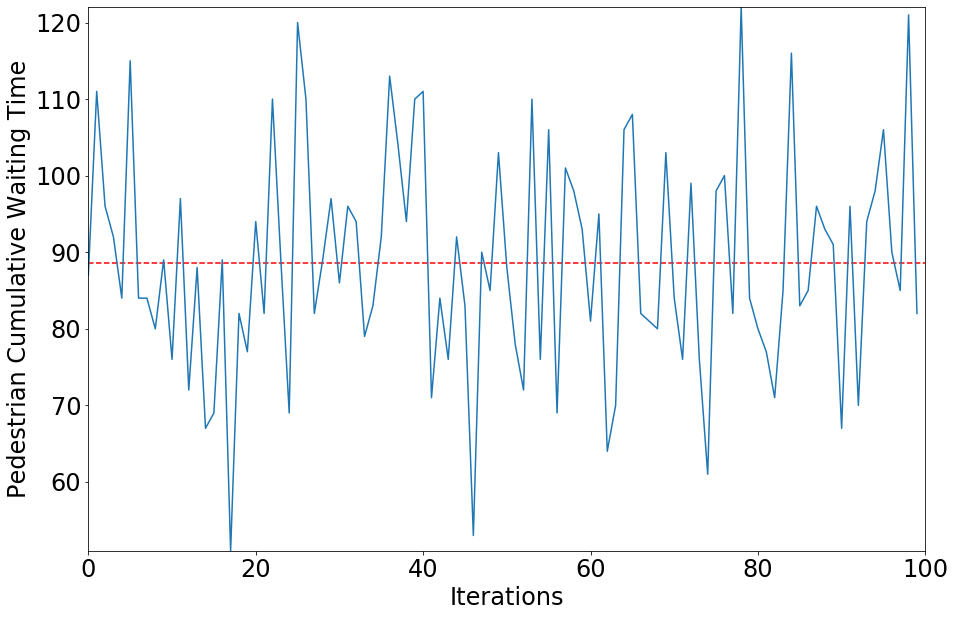

In [16]:
plt.rcParams.update({'font.size': 24})  # set bigger font size
plt.plot(pedwaiting)
plt.xlabel("Iterations")
plt.ylabel("Pedestrian Cumulative Waiting Time")
plt.margins(0)
plt.hlines(np.mean(pedwaiting), xmin=0, xmax =100, label='Mean', linestyle='--',colors = "r")
fig = plt.gcf()
fig.set_size_inches(15, 10)

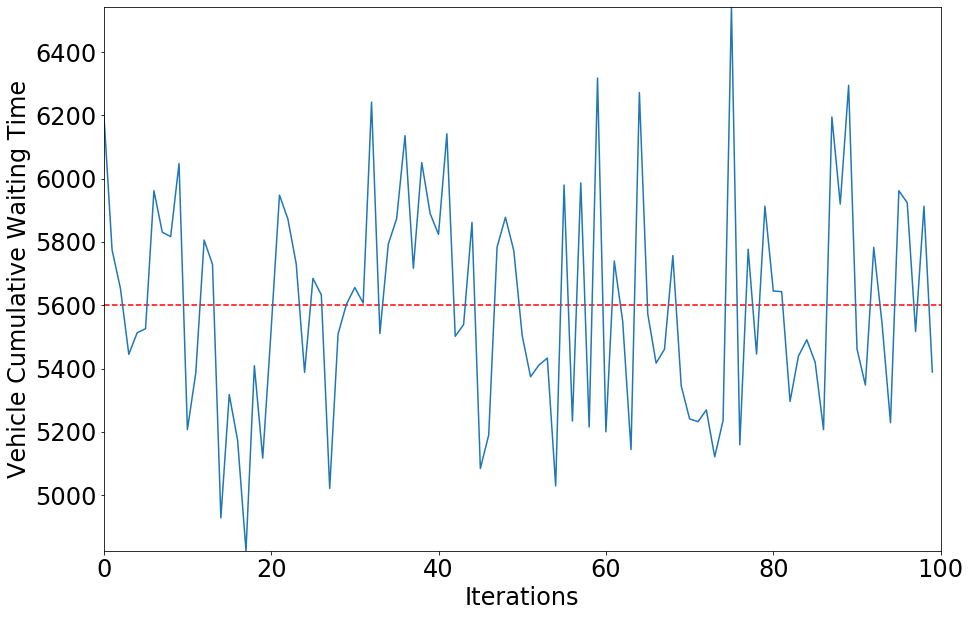

In [17]:
plt.rcParams.update({'font.size': 24})  # set bigger font size
plt.plot(vehwaiting)
plt.xlabel("Iterations")
plt.ylabel("Vehicle Cumulative Waiting Time")
plt.margins(0)
plt.hlines(np.mean(vehwaiting), xmin=0, xmax =100, label='Mean', linestyle='--',colors = "r")
fig = plt.gcf()
fig.set_size_inches(15, 10)

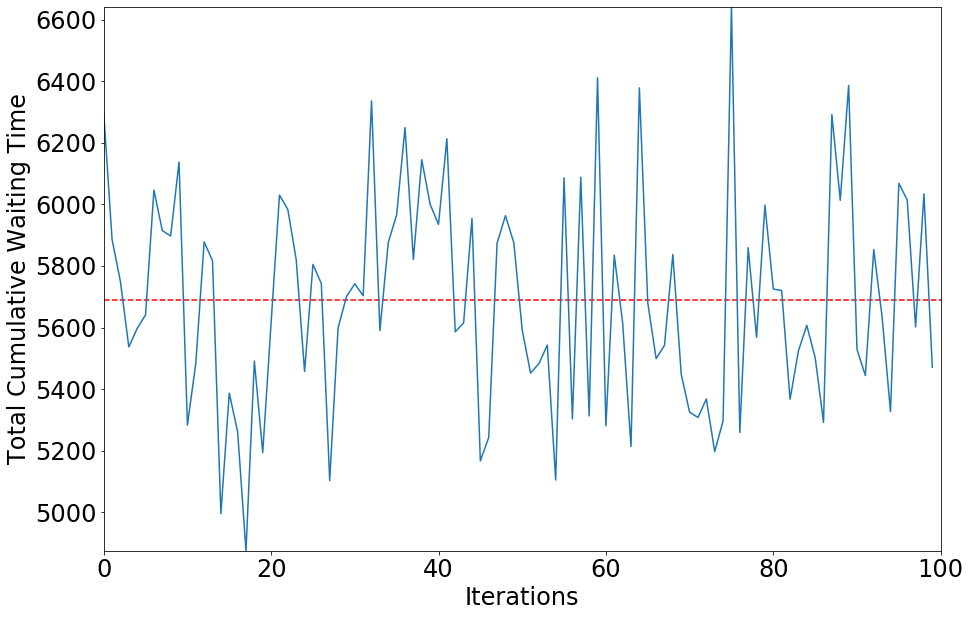

In [19]:
totalwaiting = [pedwaiting[i] + vehwaiting[i] for i in range(len(vehwaiting))]
plt.rcParams.update({'font.size': 24})  # set bigger font size
plt.plot(totalwaiting)
plt.xlabel("Iterations")
plt.ylabel("Total Cumulative Waiting Time")
plt.margins(0)
plt.hlines(np.mean(totalwaiting), xmin=0, xmax =100, label='Mean', linestyle='--',colors = "r")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

In [13]:
import numpy as np

In [14]:
np.mean(totalwaiting)

5690.03